# Prova 3
## Parte II - Algorítmos Genéticos
Uma empresa opera 2 aeronaves de pequeno porte (A1 e A2) e precisa escalar tripulação para cumprir uma rota diária de ida e volta em dois trechos por aeronave:

- A1: Cidade Juiz de Fora → Rio → Juiz de Fora (ida e volta no mesmo dia)
- A2: Cidade Juiz de Fora → Brasília → Juiz de Fora (ida e volta no mesmo dia)

O planejamento é para T=4 (D1…D4).

Em cada dia, cada aeronave que voar precisa de:

- 1 piloto
- 1 comissário(a)

**Regras trabalhistas simplificadas:**

- Cada tripulante não pode trabalhar em dias consecutivos  (descanso mínimo de 1 dia entre trabalhos).
- Se trabalhou no dia t, não pode trabalhar no dia t+1.
- Um tripulante não pode estar em duas aeronaves no mesmo dia.
- Você pode optar por  cancelar o voo de uma aeronave em determinado dia, pagando uma  penalidade (para manter o problema sempre factível, mesmo com poucas pessoas).
- Cada piloto/comissário tem um custo diário ao trabalhar.

**Objetivo: minimizar o custo total de tripulação + penalidades de cancelamento.**

**Dados da instância - Dias**
- $t ∈ {1,2,3,4}$

**Aeronaves**
- $a ∈ {A1,A2}$

**Pilotos**

| Piloto | Custo/dia |
|:------:|:---------:|
|   P1   |    520    |
|   P2   |    480    |
|   P3   |    450    |

**Comissários**

| Comissário | Custo/dia |
|:------:|:---------:|
|   C1   |    260    |
|   C2   |    240    |
|   C3   |    220    |

**Penalidade de Cancelamento**
Cancelar A1 em um dia: 800
Cancelar A2 em um dia: 800

Com essa penalidade, o modelo normalmente faz com que as aeronaves voem todos os dias, mas pode cancelar se o descanso tornar impossível ou caro demais.  


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Fixar semente para reprodutibilidade
random.seed(42)
# np.random.seed(42)

# Configurações do Espaço de Busca
N_DIAS = 4
N_AVIOES = 2
N_CARGOS = 2 # [0] Piloto, [1] Comissário

# Dados de Custos e IDs
IDS_PILOTOS = [0, 1, 2, 3]
TABELA_PILOTOS = {0: 0, 1: 520, 2: 480, 3: 450}

IDS_COMISSARIOS = [0, 1, 2, 3]
TABELA_COMISSARIOS = {0: 0, 1: 260, 2: 240, 3: 220}

PENALIDADE_CANCELAMENTO = 800
K_PENALIDADE_REGRA = 1e6 # Custo para violação de restrições

# Parte II: Formulação do Problema (Algorítmo Genético)



## Modelagem do Cromossomo e Espaço de Busca

O cromossomo é representado por uma Matriz tridimensional de dimensões $4 \times 2 \times 2$, representando (Dias, Aeronaves, Cargos).

Cada gene contém um valor inteiro que mapeia um funcionário específico:

- Identificadores (IDs):
  - 0: Ausência de tripulante (Voo cancelado).
  - 1, 2, 3: Identificadores de Pilotos ($P_1, P_2, P_3$) ou Comissários ($C_1, C_2, C_3$), dependendo do índice do cargo.

Estrutura do Indivíduo

$$X = \begin{bmatrix}
\text{Dia}_1 \\ \vdots \\ \text{Dia}_4
\end{bmatrix}, \text{ onde cada dia é }
\begin{pmatrix}
[P_{A1}, C_{A1}] \\
[P_{A2}, C_{A2}]
\end{pmatrix}$$

In [2]:
def criar_individuo():
    individuo = np.zeros((N_DIAS, N_AVIOES, N_CARGOS), dtype=int)
    for d in range(N_DIAS):
        for a in range(N_AVIOES):
            individuo[d, a, 0] = random.choice(IDS_PILOTOS)
            individuo[d, a, 1] = random.choice(IDS_COMISSARIOS)
    return individuo

# Teste:
teste_individuo = criar_individuo()
display(teste_individuo)

array([[[0, 0],
        [2, 1]],

       [[1, 1],
        [0, 0]],

       [[3, 0],
        [0, 0]],

       [[1, 1],
        [0, 1]]])

## Função de Aptidão (Fitness)

O objetivo é minimizar a função de custo total, onde o indivíduo mais apto é aquele que apresenta o menor valor de $f(ind)$:

$$f(ind) = C_{\text{cancelamento}} + C_{\text{salários}} + C_{\text{restrições}}$$

A. Custos Diretos
- Custo de Cancelamento ($C_{canc}$): Aplicado se o piloto ou o comissário estiverem ausentes ($ID=0$).

$$C_{canc} = \sum_{d=1}^{4}\sum_{a=1}^{2} 800 \cdot \mathbb{if}(x_{d, a, 0}=0 \quad or \quad x_{d, a, 1}=0)$$

- Custo de Salários ($C_{sal}$): Calculado apenas para voos confirmados.

$$C_{sal} = \sum_{d,a} (\text{Salário}(P_{id}) + \text{Salário}(C_{id})) \cdot \mathbb{if}(P_{id} \neq 0 \quad and \quad C_{id} \neq 0)$$

B. Penalidades de Restrições ($C_{restrições}$)
Para garantir a viabilidade da escala, utilizamos uma penalidade de alta magnitude ($K = 10^6$) para cada violação de regra trabalhista:
1. Descanso Mínimo ($P_{desc}$): O tripulante não pode trabalhar em dias consecutivos.

$$P_{desc} = K \cdot \sum_{d=1}^{3} \mathbb{if}(\text{trabalhou}_d \quad and \quad \text{trabalhou}_{d+1})$$

2. Unicidade de Trabalho ($P_{uni}$): Um tripulante não pode operar duas aeronaves no mesmo dia.

$$P_{uni} = K \cdot \sum_{d=1}^{4} \max(0, \text{contagem}(f_{id}) - 1)$$

3. Tripulação Incompleta ($P_{inc}$): Penaliza voos que possuem apenas um dos dois tripulantes necessários.

In [3]:
def calcular_custo_total(individuo):
    custo_cancelamento = 0
    custo_salarios = 0
    penalidade_regras = 0

    # 1. Custos Fixos (Cancelamento e Salários)
    for d in range(N_DIAS):
        for a in range(N_AVIOES):
            p = individuo[d, a, 0]
            c = individuo[d, a, 1]

            if p == 0 or c == 0:
                custo_cancelamento += PENALIDADE_CANCELAMENTO
            else:
                custo_salarios += TABELA_PILOTOS[p] + TABELA_COMISSARIOS[c]

    # 2. Avaliação de Restrições (Pilotos e Comissários)
    for cargo_idx in [0, 1]: # 0 para Pilotos, 1 para Comissários
        ids_equipe = [1, 2, 3]
        for f_id in ids_equipe:
            for d in range(N_DIAS):
                # Unicidade: Não pode estar em 2 aviões no mesmo dia
                if np.sum(individuo[d, :, cargo_idx] == f_id) > 1:
                    penalidade_regras += K_PENALIDADE_REGRA

                # Descanso: Não pode trabalhar em dias consecutivos
                if d < N_DIAS - 1:
                    trabalhou_hoje = (individuo[d, :, cargo_idx] == f_id).any()
                    trabalhou_amanha = (individuo[d+1, :, cargo_idx] == f_id).any()
                    if trabalhou_hoje and trabalhou_amanha:
                        penalidade_regras += K_PENALIDADE_REGRA

    return custo_cancelamento + custo_salarios + penalidade_regras

## Geração de Novos Indivíduos
O processo evolutivo segue quatro etapas principais para garantir a convergência e a manutenção de boas soluções:
1. Seleção por Truncamento: Ordenamos a população pelo custo e selecionamos os 50% melhores para compor o pool genético.
2. Elitismo: O melhor indivíduo da geração atual é clonado diretamente para a próxima, garantindo que a solução ótima nunca seja perdida.
3. Crossover (Cruzamento): Realizado por "ponto de corte" nos dias. O filho herda os primeiros dias de um pai e os dias restantes da mãe.
4. Mutação: Introduz variabilidade aleatória (taxa de 5%) alterando IDs de tripulantes, permitindo que o algoritmo explore novas áreas do espaço de busca.


### Funções de geração de novos indivíduos

In [4]:
def crossover(pai, mae):
    ponto = random.randint(1, N_DIAS - 1) # Seleciona um dia aleatório para herdar do pai e mãe
    filho = np.zeros_like(pai)
    filho[:ponto] = pai[:ponto].copy()
    filho[ponto:] = mae[ponto:].copy()
    return filho

def mutar(individuo, taxa_mutacao=0.05):
    mutante = individuo.copy()
    for d in range(N_DIAS):
        for a in range(N_AVIOES):
            if random.random() < taxa_mutacao:
                mutante[d, a, 0] = random.choice(IDS_PILOTOS)
            if random.random() < taxa_mutacao:
                mutante[d, a, 1] = random.choice(IDS_COMISSARIOS)
    return mutante

def gerar_nova_populacao(populacao_atual, tamanho_populacao):
    # Ordenar por custo (Aptidão)
    pop_ordenada = sorted(populacao_atual, key=lambda x: x['custo'])

    # Elitismo: Mantém o melhor absoluto
    nova_geracao = [pop_ordenada[0]]

    # Selecionar os 50% melhores como pais potenciais
    aptos = pop_ordenada[:tamanho_populacao // 2]

    while len(nova_geracao) < tamanho_populacao:
        pai = random.choice(aptos)
        mae = random.choice(aptos)

        genes_filho = crossover(pai['genes'], mae['genes'])
        genes_mutados = mutar(genes_filho)

        nova_geracao.append({
            'genes': genes_mutados,
            'custo': calcular_custo_total(genes_mutados)
        })
    return nova_geracao

### Função de plot

In [5]:
def exibir_escala(melhor_individuo):
    genes = melhor_individuo['genes']
    custo_total = melhor_individuo['custo']

    print("\n=== Solução Ótima Encontrada ===")
    print(f"Custo Total Mínimo: R$ {custo_total:.2f}")
    print("-" * 60)
    print(f"{'Dia':<5} | {'Aeronave':<10} | {'Status':<10} | {'Piloto':<10} | {'Comissário':<11}")
    print("-" * 60)

    for d in range(N_DIAS):
        for a in range(N_AVIOES):
            p_id = genes[d, a, 0]
            c_id = genes[d, a, 1]

            dia_str = f"D{d+1}"
            aero_str = f"A{a+1}"

            # Se algum dos dois for 0, o voo é cancelado
            if p_id == 0 or c_id == 0:
                status = "CANCELADO"
                piloto_info = "-"
                comiss_info = "-"
            else:
                status = "Confirmado"
                custo_p = TABELA_PILOTOS[p_id]
                custo_c = TABELA_COMISSARIOS[c_id]
                piloto_info = f"P{p_id} ({custo_p})"
                comiss_info = f"C{c_id} ({custo_c})"

            print(f"{dia_str:<5} | {aero_str:<10} | {status:<10} | {piloto_info:<10} | {comiss_info:<11}")

        print("-" * 60)

# Rodar exercício


=== Solução Ótima Encontrada ===
Custo Total Mínimo: R$ 5940.00
------------------------------------------------------------
Dia   | Aeronave   | Status     | Piloto     | Comissário 
------------------------------------------------------------
D1    | A1         | Confirmado | P2 (480)   | C1 (260)   
D1    | A2         | Confirmado | P3 (450)   | C3 (220)   
------------------------------------------------------------
D2    | A1         | CANCELADO  | -          | -          
D2    | A2         | Confirmado | P1 (520)   | C2 (240)   
------------------------------------------------------------
D3    | A1         | CANCELADO  | -          | -          
D3    | A2         | Confirmado | P2 (480)   | C1 (260)   
------------------------------------------------------------
D4    | A1         | Confirmado | P3 (450)   | C3 (220)   
D4    | A2         | Confirmado | P1 (520)   | C2 (240)   
------------------------------------------------------------


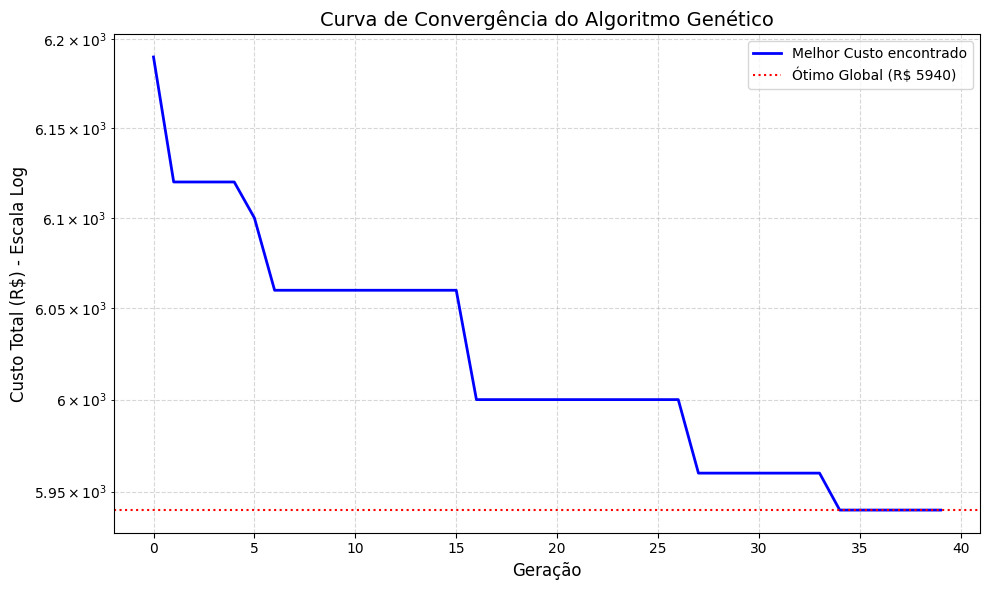

In [9]:
# Parâmetros de execução
TAMANHO_POP = 200
N_GERACOES = 40

# Inicialização
populacao = []
for _ in range(TAMANHO_POP):
    g = criar_individuo()
    populacao.append({'genes': g, 'custo': calcular_custo_total(g)})

# Loop Evolutivo
historico_melhor_custo = []
for g in range(N_GERACOES):
    populacao = gerar_nova_populacao(populacao, TAMANHO_POP)
    historico_melhor_custo.append(populacao[0]['custo'])
    # if g % 10 == 0:
        # print(f"Geração {g:03d} | Melhor Custo: R$ {melhor_c[-1]:.2f}")

exibir_escala(populacao[0])

plt.figure(figsize=(10, 6))
plt.plot(historico_melhor_custo, label='Melhor Custo encontrado', color='blue', linewidth=2)

plt.yscale('log')

plt.title('Curva de Convergência do Algoritmo Genético', fontsize=14)
plt.xlabel('Geração', fontsize=12)
plt.ylabel('Custo Total (R$) - Escala Log', fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()

# Linha opcional indicando o ótimo conhecido
plt.axhline(y=5940, color='red', linestyle=':', label='Ótimo Global (R$ 5940)')
plt.legend()

plt.tight_layout()
plt.show()